In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [13,5]

In [3]:
# ---------------------------------------------------------------
# Load Data
# ---------------------------------------------------------------
input_dir = "./data/"

train_file = os.path.join(input_dir, "train.csv")
test_file = os.path.join(input_dir, "test.csv")

train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

X = train.iloc[:,:-1]
y = train.iloc[:,-1]


# ---------------------------------------------------------------
# Map features
# ---------------------------------------------------------------
# Map categorical variables with one-hot encoding
X_transformed = pd.get_dummies(X)
print(X_transformed.shape)

# Drop NAs (because regression tree can't handle NAs)
X_transformed.dropna(axis=1, how='any', inplace=True)
print(X_transformed.shape)


# ---------------------------------------------------------------
# Split to train and test set
# ---------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2)

print("feature:", X_train.shape[1])
print("num train samples:", X_train.shape[0])
print("num valid samples:", X_test.shape[0])

(1460, 289)
(1460, 286)
feature: 286
num train samples: 1168
num valid samples: 292


## Boosting
- trees grown sequentially
- learns slowly
- depends strongly on trees that already have been grown
- does not require bootstrap sample; tree fitted on modified version of original data set
- 3 tuning parameters:
    - number of trees (too many => overfit)
    - shrinkage parameter (learning rate)
    - number of splits in tree
    
*Reference: Introduction to Statistical Learning pg.321 "Boosting"*

- http://scikit-learn.org/stable/modules/ensemble.html#adaboost
- [`sklearn.ensemble.AdaBoostClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

> The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights w_1, w_2, ..., w_N to each of the training samples. Initially, those weights are all set to w_i = 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF].


In [4]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=1)
boost = boost.fit(X_train, y_train)

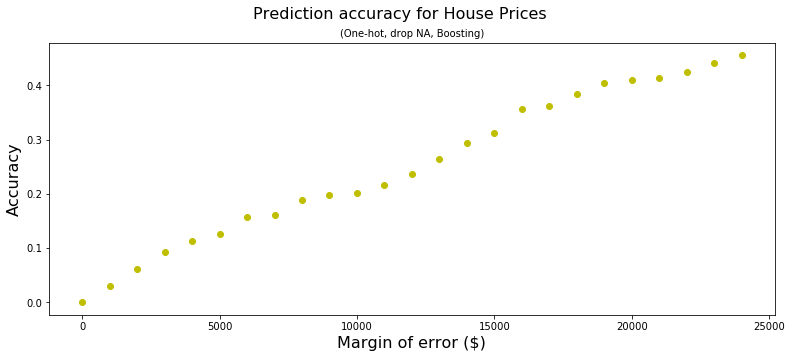

In [5]:
def evaluation(clf, margin = 5000):
    def _eval(m):
        y_hat = clf.predict(X_test)
        answer_within_range = (y_test+m > y_hat) & (y_hat > y_test-m)
        return(sum(answer_within_range) / len(answer_within_range))
    
    if type(margin) in [list, range]:
        return([_eval(m) for m in margin])
    else:
        return(_eval(margin))

    
# ---------------------------------------------------------------    
# Evaluate
# ---------------------------------------------------------------
margins = range(0, 25000, 1000)

plt.plot(margins, evaluation(boost, margins), 'yo')
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Margin of error ($)', fontsize=16)
plt.suptitle('Prediction accuracy for House Prices', fontsize=16)
plt.title('(One-hot, drop NA, Boosting)', fontsize=10)

## Tuning the parameters

In [6]:
num_trees = [25, 50, 100, 200]
learn_rates = [1, 0.1, 0.01, 0.001]

In [7]:
clfs = {}
for i in num_trees:
    for j in learn_rates:
        clf_id = "%s_%s" % (i, j)
        clfs[clf_id] = AdaBoostClassifier(n_estimators=i, learning_rate=j, random_state=1)
        clfs[clf_id] = clfs[clf_id].fit(X_train, y_train)

In [8]:
margins = range(0, 25000, 1000)

evals = {}
for k in clfs.keys():
    evals[k] = evaluation(clfs[k], margins)

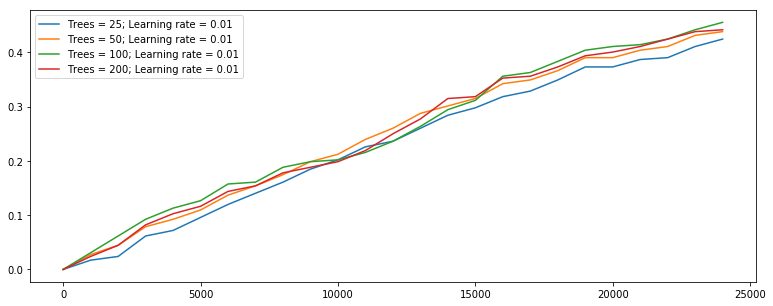

In [9]:
for k in clfs.keys():
    num_tree, learn_rate = k.split("_")
    
    if learn_rate == "0.01":
        label = "Trees = {}; Learning rate = {}".format(num_tree, learn_rate)
        plt.plot(margins, evals[k], label=label)

plt.legend(loc='upper left')

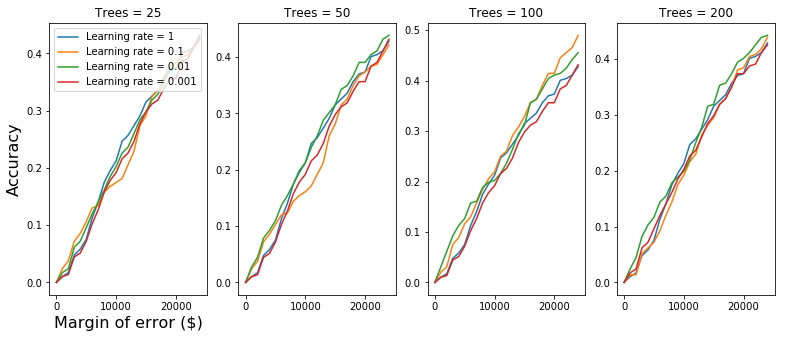

In [10]:
num_trees = [25, 50, 100, 200]
learn_rates = [1, 0.1, 0.01, 0.001]

f, axarr = plt.subplots(1,4)

counter = 0
for num_tree in num_trees:
    for learn_rate in learn_rates:
        key = "%s_%s" % (num_tree, learn_rate)
        label = "Learning rate = {}".format(learn_rate)
        axarr[counter].plot(margins, evals[key], label=label)
    axarr[counter].set_title("Trees = %s" % num_tree)
    if counter == 0:
        axarr[counter].legend(loc='upper left')
        axarr[counter].set_ylabel('Accuracy', fontsize=16)
        axarr[counter].set_xlabel('Margin of error ($)', fontsize=16)
    counter += 1

- Learning rate of 0.01 gave the more accurate predictions

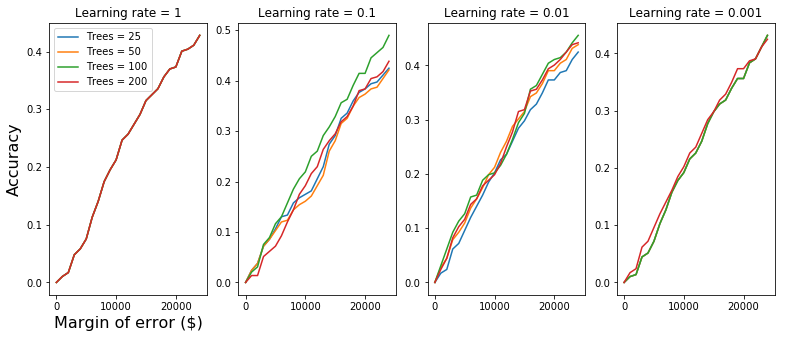

In [11]:
num_trees = [25, 50, 100, 200]
learn_rates = [1, 0.1, 0.01, 0.001]

f, axarr = plt.subplots(1,4)

counter = 0
for learn_rate in learn_rates:
    for num_tree in num_trees:
        key = "%s_%s" % (num_tree, learn_rate)
        label = "Trees = %s" % num_tree
        axarr[counter].plot(margins, evals[key], label=label)
    axarr[counter].set_title("Learning rate = %s" % learn_rate)
    if counter == 0:
        axarr[counter].legend(loc='upper left')
        axarr[counter].set_ylabel('Accuracy', fontsize=16)
        axarr[counter].set_xlabel('Margin of error ($)', fontsize=16)
    counter += 1

- Too low and too high of a learning rate ... results are comparable regardless of number of trees